# Evaluation of the final CNN model

The original final evaluation was misleading as the ealry stopping parameter had been used incorrectly. This notebook fixes this issue.

The model was chosen in 7_CNN_model_comparison.ipynb and the hyperparameters chosen from 8_CNN_hyperparameter.ipynb.
The early stopping patience to use was decided using notebook 9.

First the model is trained on subjects A, B, D, E, F.
The model is then evaluated on the test subject C. Up until this point the model has not been exposed to this data.

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [1]:
# Plot graphs inline
%matplotlib inline

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/doppler_spectrograms/3/'

RESULTS_PATH = BASE_PATH + 'results/CNN_final_model_evaluation/'
HYPERPARAMETER_PATH = BASE_PATH + 'results/CNN_hyperparameter_search/'
MODEL_PATH = BASE_PATH + 'models/CNN_final_model_evaluation/'

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
    
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

Import remaining packages

In [3]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
# ! pip install git+https://github.com/scikit-optimize/scikit-optimize/ 
from skopt import load

In [5]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup

In [6]:
SAVE_RESULTS_TEST_C = False
SAVE_GRAPHS_TEST_C = True

SAVE_RESULTS_20 = False
SAVE_GRAPHS_20 = True

SAVE_RESULTS_6_FOLD = False
SAVE_GRAPHS_6_FOLD = True

In [0]:
# Patience chosen from notebook 9
nb_epoch = 100
# nb_epoch = 1 #testing
patience = 7

In [0]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

# input image dimensions
img_rows, img_cols = 75, 75

users = ["A", "B", "C", "D", "E", "F"] 

In [0]:
def load_data(user_letter):
    """
    load the data and labels associated with a particular user/subject (interchangeable)
    :param user_letter: Letter representing subject/user (A-F)
    :type user_letter: str
    :return: data and labels
    :rtype: tuple of the form (data, labels)
    """
    with open(DATA_PATH + user_letter + "_data.pkl", 'rb') as data_file:
        data = pickle.load(data_file)
        data = data.reshape(data.shape[0], 1, 75, 75)
        
    with open(DATA_PATH + user_letter + "_labels.pkl", 'rb') as labels_file:
        labels = pickle.load(labels_file)
        labels = np.reshape(labels, (len(labels), 1))

    return data, labels

In [0]:
datasets = {}
for user in users:
    data, labels = load_data(user)
    datasets[user] = {"data":data, "labels":labels}

## Define Model

In [0]:
def make_model(nb_filters, img_rows, img_cols, nb_classes, activation,
               dropout, num_dense_nodes, num_dense_layers,
               kernel_size, pooling_size):
    """
    Make and return the CNN model
    :param nb_filters: Number of filters to use in layers 1,2 and 3,4 respectively
    :type nb_filters: str containing the number of filters for the first two layers followed by 
    the last two layers, for example: "16-32"
    :param img_rows: image height
    :type img_rows: int
    :param img_cols: image width
    :type img_cols: int
    :param nb_classes: Number of classes to be predicted
    :type nb_classes: int
    :param activation: Activation function to use after each conv and dense layer
    :type activation: Keras activation function
    :param dropout: dropout rate for dropout layers
    :type dropout: float
    :param num_dense_nodes: number of dense nodes in dense layer
    :type num_dense_nodes: int
    :param num_dense_layers: number of dense layers
    :type num_dense_layers: int
    :param kernel_size: kernel size to use
    :type kernel_size: int but will be converted to tuple (int, int) 
                        internally as kernel is a square
    :param pooling_size: pool size
    :type pooling_size: int but will be converted to tuple (int, int)
                        internally as requires vertical and horizontal
    :return: CNN model
    :rtype: Keras sequential model
    """
    kernel_size = (kernel_size, kernel_size)
    pooling_size = (pooling_size, pooling_size)
    
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, kernel_size, padding='same', input_shape=(1, img_rows, img_cols), activation=activation))
    model.add(Convolution2D(size_1, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Convolution2D(size_2, kernel_size, padding='same', activation=activation))
    model.add(Convolution2D(size_2, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Flatten())
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

## Train Model Function

In [0]:
def train_model(train_data, train_labels, validation_data, validation_labels, hyperparameters, epochs, patience):
    """
    Make and train the CNN model
    :param train_data: Data to train the model on
    :type train_data: array of images represented as numpy arrays
    :param train_labels: Labels corresponding to the training data
    :type train_labels: array of integers representing the labels in the same order as train_data
    :param validation_data: Data to validate the model on
    :type validation_data: array of images represented as numpy arrays
    :param validation_labels: Labels corresponding to the validation data
    :type validation_labels: array of integers representing the labels in the same order as validation_data
    :param hyperparameters: Selected hyperparameters 
    :type hyperparameters: dictionary
    :param epochs: number of epochs to train for
    :type epochs: int
    :param patience: patience value for early stopping (-1 for no early stopping)
    :type patience: int
    :return: training history and trained model
    :rtype: tuple of the form (history, model)
    """
    parameters = hyperparameters
    model = make_model("8-16", img_rows, img_cols, nb_classes, parameters[2],
               parameters[3], parameters[4], parameters[5],
               parameters[6], parameters[7])
    
    optimizer = parameters[0] 
    learning_rate = parameters[1]
    if optimizer == 'adam':
        selected_optimizer = Adam(lr=learning_rate)

    elif optimizer == 'sgd_standard':
        selected_optimizer = SGD(lr=learning_rate)

    else:
        # nestrov momentum
        selected_optimizer = SGD(lr=learning_rate, decay=1e-6, momentum=0.9,
                                 nesterov=True)

    model.compile(loss='categorical_crossentropy',
                  optimizer=selected_optimizer,
                  metrics=['accuracy'])
    
    callback_list = []
    if patience != -1:
        early_stopping = EarlyStopping(monitor='val_acc', patience=patience)
        callback_list.append(early_stopping)
        
    history = model.fit(train_data, train_labels,
                        batch_size=parameters[8],
                        epochs=epochs,
                        shuffle=True, 
                        validation_data=(validation_data, validation_labels),
                        callbacks=callback_list,
                        verbose=0)
    
    return history, model

## Evaluate Model function

In [0]:
def evaluate_model(model, test_data, test_labels, batch_size, target_names):
    evaluation = model.evaluate(test_data, test_labels,
                                batch_size=batch_size, verbose=1)

    loss = evaluation[0]
    accuracy = evaluation[1]

    test_pred = model.predict_classes(test_data)
    report = classification_report(np.argmax(test_labels,axis=1),
                                   test_pred, target_names=target_names)
    conf_matrix = confusion_matrix(np.argmax(test_labels,axis=1), test_pred)
    return {
        "loss": loss,
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": conf_matrix
    }

### Load hyperparameter results

In [0]:
# needed for loading results (objective needs to be defined)
def objective():
    return 0

In [14]:
dimensions = ['optimizer', 'learning_rate', 'activation', 'dropout',
              'num_dense_nodes', 'num_dense_layers', 'kernel_size',
              'pooling_size', 'batch_size']

res_gp = load(HYPERPARAMETER_PATH + "res_gp_complete.pkl")
parameters = res_gp.x

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


AttributeError: ignored

In [0]:
for index, parameter in enumerate(parameters):
    print(dimensions[index] + ":", parameter)

# Evaluating on subject C

In [0]:
def split_train_validation_test(test_user, total_folds=5, validation_fold=0):
    # split by user then action
    labels = np.arange(0, 7)
    actions = {}
    for user in users:
        actions[user] = {}
        for label in labels:
            actions[user][str(label)] = []
        
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        for index, label in enumerate(labels):
            actions[user][str(label[0])].append(data[index])
        
    # convert to numpy array
    labels = np.arange(0, 7)
    for user in users:
        for label in labels:
            actions[user][str(label)] = np.array(actions[user][str(label)])
            
    train_labels = []
    train_data = []
    validation_labels = []
    validation_data = []
    test_labels = []
    test_data = []
    # each user A->F
    for user in users:
        # 0 -> 6
        for label in labels:            
            if user == test_user:
                testing_data = actions[user][str(label)]
                testing_labels = np.full(testing_data.shape[0], label)
                test_data.append(testing_data)
                test_labels.append(testing_labels)  
                
            else:
                # for example, if using 5 folds splits data into 5 subsets
                split_actions = np.array_split(actions[user][str(label)], total_folds)
                training_data = []
                validating_data = []
                for fold in range(total_folds):
                    if fold == validation_fold:
                        validating_data.append(split_actions[fold])
                    else:
                        training_data.append(split_actions[fold])

                training_data = np.concatenate(training_data, axis=0)
                training_labels = np.full(training_data.shape[0], label)
                validating_data = np.concatenate(validating_data, axis=0)
                validating_labels = np.full(validating_data.shape[0], label)

                train_data.append(training_data)
                train_labels.append(training_labels)
                validation_data.append(validating_data)
                validation_labels.append(validating_labels)   
            
    train_labels = np.concatenate(train_labels, axis=0)
    train_data = np.concatenate(train_data, axis=0)
    validation_labels = np.concatenate(validation_labels, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    test_labels = np_utils.to_categorical(test_labels, nb_classes)
    
    train_data = train_data.astype('float32')/255
    validation_data = validation_data.astype('float32')/255
    test_data = test_data.astype('float32')/255
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels,
        "test_data": test_data,
        "test_labels": test_labels
       }

## Train Model

In [0]:
data_split = split_train_validation_test("C") # subject c is test subject

# 80% of each subject (excluding C)
train_data = data_split["train_data"]
train_labels = data_split["train_labels"]

# 20% taken from each subject (excluding C)
validation_data = data_split["validation_data"]
validation_labels = data_split["validation_labels"]

# subject C
test_data = data_split["test_data"]
test_labels = data_split["test_labels"]

In [0]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(29575, 1, 75, 75)
(7410, 1, 75, 75)
(7966, 1, 75, 75)


In [0]:
history, model = train_model(train_data, train_labels,
                             validation_data, validation_labels,
                             parameters, nb_epoch, patience)

Train on 36985 samples, validate on 7966 samples
Epoch 1/1
36985/36985 [==============================] - 57s 2ms/step - loss: 1.0214 - acc: 0.6000 - val_loss: 0.9798 - val_acc: 0.5357


## Evaluate Model

In [0]:
results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
results["history"] = history.history

7966/7966 [==============================] - 3s 385us/step


## Save Results

In [0]:
if SAVE_RESULTS_TEST_C:
    with open(RESULTS_PATH + "results_test_c.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_test_c.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

In [0]:
print("Accuracy:",results["accuracy"]*100)

Accuracy: 77.32864703600532


### Accuracy

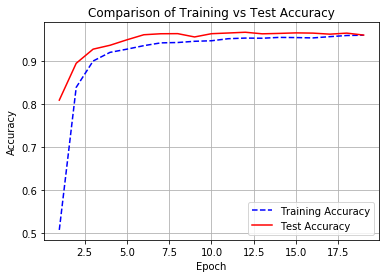

In [0]:
training_acc = results["history"]['acc']
test_acc = results["history"]['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'b--')
plt.plot(epoch_count, test_acc, 'r-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Comparison of Training vs Test Accuracy")
plt.grid()
if SAVE_GRAPHS_TEST_C:
    plt.savefig(RESULTS_PATH + "training_vs_test_acc.pdf", format='pdf')
plt.show()

### Loss

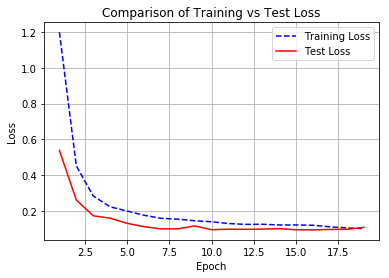

In [0]:
training_loss = results["history"]['loss']
test_loss = results["history"]['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b--')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Comparison of Training vs Test Loss")
plt.grid()
if SAVE_GRAPHS_TEST_C:
    plt.savefig(RESULTS_PATH + "training_vs_test_loss.pdf", format='pdf')
plt.show()

### Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, classes, save=False, path='/'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save:
        plt.savefig(path, format='pdf')
    plt.show()

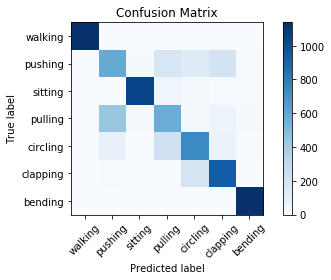

In [0]:
plot_confusion_matrix(results["confusion_matrix"], target_names,
                      save=SAVE_GRAPHS_TEST_C, path=RESULTS_PATH + "confusion_matrix.pdf")

In [0]:
K.clear_session()

# Evaluating on subset of the data (all subjects) 5-Fold
use 60% for training, 20% for validation (early stopping) and the final 20% for testing.

In [0]:
# pass in percentage to make test set
# fold = 0,1,2,3,4
def split_data(test_fold, validation_fold, total_folds):
    # split by user then action
    labels = np.arange(0, 7)
    actions = {}
    for user in users:
        actions[user] = {}
        for label in labels:
            actions[user][str(label)] = []
        
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        for index, label in enumerate(labels):
            actions[user][str(label[0])].append(data[index])        
        
    labels = np.arange(0, 7)
    for user in users:
        for label in labels:
            actions[user][str(label)] = np.array(actions[user][str(label)])
            
    train_labels = []
    train_data = []
    validation_labels = []
    validation_data = []
    test_labels = []
    test_data = []
    # each user A->F
    for user in users:
        # 0 -> 6
        for label in labels:
            # for example, if using 5 folds splits data into 5 subsets
            split_actions = np.array_split(actions[user][str(label)], total_folds)
            training_data = []
            validating_data = []
            testing_data = []
            for fold in range(total_folds):
                if fold == test_fold:
                    testing_data.append(split_actions[fold])
                    
                elif fold == validation_fold:
                    validating_data.append(split_actions[fold])
                    
                else:
                    training_data.append(split_actions[fold])
                    
            training_data = np.concatenate(training_data, axis=0)
            training_labels = np.full(training_data.shape[0], label)
            validating_data = np.concatenate(validating_data, axis=0)
            validating_labels = np.full(validating_data.shape[0], label)
            testing_data = np.concatenate(testing_data, axis=0)
            testing_labels = np.full(testing_data.shape[0], label)
            
            train_data.append(training_data)
            train_labels.append(training_labels)
            validation_data.append(validating_data)
            validation_labels.append(validating_labels)
            test_data.append(testing_data)
            test_labels.append(testing_labels)   
            
    train_labels = np.concatenate(train_labels, axis=0)
    train_data = np.concatenate(train_data, axis=0)
    validation_labels = np.concatenate(validation_labels, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    test_labels = np_utils.to_categorical(test_labels, nb_classes)
    
    train_data = train_data.astype('float32')/255
    validation_data = validation_data.astype('float32')/255
    test_data = test_data.astype('float32')/255
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels,
        "test_data": test_data,
        "test_labels": test_labels
       }

In [0]:
k_fold_results = {}
number_of_folds = 5
for fold in range(number_of_folds):
    k_fold_results[str(fold)] = {}

In [0]:
average_accuracy = 0
average_loss = 0
for fold in range(number_of_folds):
    test_fold = fold
    validation_fold = (test_fold + 1) % number_of_folds
    print("Fold:", fold)
    
    data_split = split_data(test_fold, validation_fold, number_of_folds)
    
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    test_data = data_split["test_data"]
    test_labels = data_split["test_labels"]

    history, model = train_model(train_data, train_labels,
                                 validation_data, validation_labels,
                                 parameters, nb_epoch, patience)
    
    results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
    average_accuracy += results["accuracy"]
    average_loss += results["loss"]
    k_fold_results[str(fold)]["accuracy"] = results["accuracy"]
    k_fold_results[str(fold)]["loss"] = results["loss"]
    
k_fold_results["average_accuracy"] = average_accuracy/number_of_folds
k_fold_results["average_loss"] = average_loss/number_of_folds

Fold: 0
(35945, 1, 75, 75) (35945, 7) (9006, 1, 75, 75) (9006, 7)
Train on 35945 samples, validate on 9006 samples
Epoch 1/1
9006/9006 [==============================] - 3s 354us/step
Fold: 1
(35945, 1, 75, 75) (35945, 7) (9006, 1, 75, 75) (9006, 7)
Train on 35945 samples, validate on 9006 samples
Epoch 1/1
9006/9006 [==============================] - 3s 354us/step
Fold: 2
(35945, 1, 75, 75) (35945, 7) (9006, 1, 75, 75) (9006, 7)
Train on 35945 samples, validate on 9006 samples
Epoch 1/1
9006/9006 [==============================] - 3s 377us/step
Fold: 3
(35982, 1, 75, 75) (35982, 7) (8969, 1, 75, 75) (8969, 7)
Train on 35982 samples, validate on 8969 samples
Epoch 1/1
8969/8969 [==============================] - 3s 358us/step
Fold: 4
(35987, 1, 75, 75) (35987, 7) (8964, 1, 75, 75) (8964, 7)
Train on 35987 samples, validate on 8964 samples
Epoch 1/1
8964/8964 [==============================] - 3s 371us/step


## Save Results

In [0]:
if SAVE_RESULTS_20:
    with open(RESULTS_PATH + "results_test_20.pkl", 'wb') as results_file:
        pickle.dump(k_fold_results, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_test_20.pkl", 'rb') as results_file:
    k_fold_results = pickle.load(results_file)

## Visualize Results

In [0]:
print("Average Accuracy:", k_fold_results["average_accuracy"]*100)
print("Average Loss:", k_fold_results["average_loss"])

Average Accuracy: 93.84664399196652
Average Loss: 0.20795073051906865


### Accuracy Fold Distribution

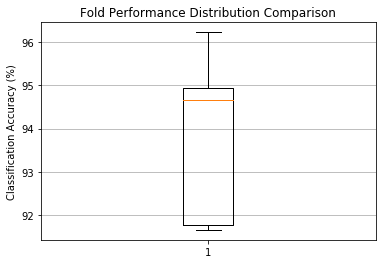

In [0]:
accuracies = []
for fold in range(number_of_folds):
    accuracies.append(k_fold_results[str(fold)]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
# plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_20:
     plt.savefig(RESULTS_PATH + "boxplot_20.pdf", format='pdf')

In [0]:
K.clear_session()

# Six-Fold Cross-Validation
Same method as employed when comparing the original model except this time user all users.

In [0]:
results_six_fold = {}
for user in users:
    results_six_fold[user] = {}

In [0]:
average_accuracy = 0
average_loss = 0
for user in users:
    data_split = split_train_validation_test(user)
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    test_data = data_split["test_data"]
    test_labels = data_split["test_labels"]
    
    history, model = train_model(train_data, train_labels, validation_data, validation_labels, parameters, nb_epoch, patience)
    
    results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
    average_accuracy += results["accuracy"]
    average_loss += results["loss"]
    results_six_fold[user]["accuracy"] = results["accuracy"]
    results_six_fold[user]["loss"] = results["loss"]

results_six_fold["avg_loss"] = average_loss/len(users)
results_six_fold["avg_acc"] = average_accuracy/len(users)
print("Average Loss:", average_loss/len(users))
print("Average Accuracy:", average_accuracy/len(users))

ResourceExhaustedError: OOM when allocating tensor with shape[576,8,75,75] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_7/Adam/gradients/conv2d_30/convolution_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@training_7/Adam/gradients/conv2d_30/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_7/Adam/gradients/conv2d_30/convolution_grad/ShapeN, conv2d_30/kernel/read, training_7/Adam/gradients/conv2d_30/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


## Save Results

In [0]:
if SAVE_RESULTS_6_FOLD:
    with open(RESULTS_PATH + "results_6_fold.pkl", 'wb') as results_file:
        pickle.dump(results_six_fold, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_6_fold.pkl", 'rb') as results_file:
    results_six_fold = pickle.load(results_file)

## Visualize Results

In [0]:
print("Average Accuracy:", results_six_fold["avg_acc"]*100)
print("Average Loss:", results_six_fold["avg_loss"])

Average Accuracy: 76.80047597558102
Average Loss: 1.616423382245684


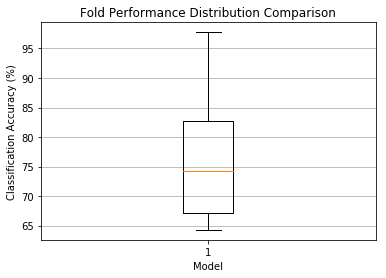

In [0]:
accuracies = []
for user in users:
    accuracies.append(results_six_fold[user]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
     plt.savefig(RESULTS_PATH + "boxplot_6_fold.pdf", format='pdf')

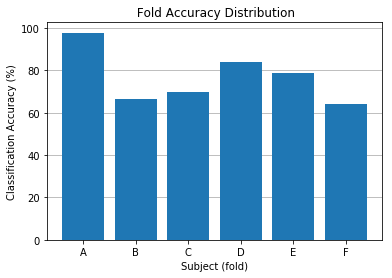

In [0]:
plt.bar(range(len(users)), accuracies, zorder=3)
plt.xticks(range(len(users)), users)
plt.xlabel("Subject (fold)")
plt.ylabel("Classification Accuracy (%)")
plt.title(" Fold Accuracy Distribution")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
    plt.savefig(RESULTS_PATH + "fold_accuracy_distribution_6_fold.pdf", format='pdf')
plt.show()

# Original Model Parameters

In [0]:
SAVE_RESULTS_TEST_C_BASE = False
SAVE_GRAPHS_TEST_C_BASE = True

SAVE_RESULTS_20_BASE = False
SAVE_GRAPHS_20_BASE = True

SAVE_RESULTS_6_FOLD_BASE = True
SAVE_GRAPHS_6_FOLD_BASE = True

In [0]:
nb_epochs = 20
batch_size = 64

In [0]:
def make_base_model():   
    model = Sequential(name="Base")

    model.add(Convolution2D(64, (3, 3), padding='same',
                            input_shape=(1, img_rows, img_cols), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    
    optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9,
                    nesterov=True)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

## Evaluate on Subject C

In [0]:
data_split = split_train_validation_test("C") # subject c is test subject

# 80% of each subject (excluding C)
train_data = data_split["train_data"]
train_labels = data_split["train_labels"]

# 20% taken from each subject (excluding C)
validation_data = data_split["validation_data"]
validation_labels = data_split["validation_labels"]

# subject C
test_data = data_split["test_data"]
test_labels = data_split["test_labels"]

In [24]:
model = make_base_model()

history = model.fit(train_data, train_labels,
                    batch_size=batch_size,
                    epochs=nb_epochs,
                    shuffle=True, 
                    validation_data=(validation_data, validation_labels),
                    verbose=1)

Train on 29575 samples, validate on 7410 samples
Epoch 1/20
29575/29575 [==============================] - 64s 2ms/step - loss: 0.8306 - acc: 0.6913 - val_loss: 0.3613 - val_acc: 0.8565
Epoch 2/20
29575/29575 [==============================] - 63s 2ms/step - loss: 0.3524 - acc: 0.8841 - val_loss: 0.2348 - val_acc: 0.9035
Epoch 3/20
29575/29575 [==============================] - 63s 2ms/step - loss: 0.2380 - acc: 0.9213 - val_loss: 0.1403 - val_acc: 0.9506
Epoch 4/20
29575/29575 [==============================] - 63s 2ms/step - loss: 0.1859 - acc: 0.9360 - val_loss: 0.1336 - val_acc: 0.9536
Epoch 5/20
29575/29575 [==============================] - 62s 2ms/step - loss: 0.1564 - acc: 0.9449 - val_loss: 0.1070 - val_acc: 0.9638
Epoch 6/20
29575/29575 [==============================] - 62s 2ms/step - loss: 0.1405 - acc: 0.9506 - val_loss: 0.1054 - val_acc: 0.9638
Epoch 7/20
29575/29575 [==============================] - 62s 2ms/step - loss: 0.1285 - acc: 0.9541 - val_loss: 0.0943 - val_acc:

In [27]:
results = evaluate_model(model, test_data, test_labels, batch_size, target_names)
results["history"] = history.history

7966/7966 [==============================] - 5s 670us/step


## Save Results

In [0]:
if SAVE_RESULTS_TEST_C_BASE:
    with open(RESULTS_PATH + "results_test_c_base.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_test_c_base.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

In [30]:
print("Accuracy:", results["accuracy"]*100)

Accuracy: 77.26587998995733


In [0]:
K.clear_session()

# Evaluating on subset of the data (all subjects) 5-Fold
use 60% for training, 20% for validation (early stopping) and the final 20% for testing.

In [0]:
k_fold_results = {}
number_of_folds = 5
for fold in range(number_of_folds):
    k_fold_results[str(fold)] = {}

In [33]:
average_accuracy = 0
average_loss = 0
for fold in range(number_of_folds):
    test_fold = fold
    validation_fold = (test_fold + 1) % number_of_folds
    print("Fold:", fold)
    
    data_split = split_data(test_fold, validation_fold, number_of_folds)
    
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    test_data = data_split["test_data"]
    test_labels = data_split["test_labels"]
    
    model = make_base_model()

    history = model.fit(train_data, train_labels,
                        batch_size=batch_size,
                        epochs=nb_epochs,
                        shuffle=True, 
                        validation_data=(validation_data, validation_labels),
                        verbose=1)
    
    results = evaluate_model(model, test_data, test_labels, batch_size, target_names)
    average_accuracy += results["accuracy"]
    average_loss += results["loss"]
    k_fold_results[str(fold)]["accuracy"] = results["accuracy"]
    k_fold_results[str(fold)]["loss"] = results["loss"]
    
k_fold_results["average_accuracy"] = average_accuracy/number_of_folds
k_fold_results["average_loss"] = average_loss/number_of_folds

Fold: 0
Train on 26939 samples, validate on 9006 samples
Epoch 1/20
26939/26939 [==============================] - 60s 2ms/step - loss: 0.9433 - acc: 0.6470 - val_loss: 0.4038 - val_acc: 0.8558
Epoch 2/20
26939/26939 [==============================] - 58s 2ms/step - loss: 0.4286 - acc: 0.8546 - val_loss: 0.2754 - val_acc: 0.8945
Epoch 3/20
26939/26939 [==============================] - 58s 2ms/step - loss: 0.2815 - acc: 0.9048 - val_loss: 0.2656 - val_acc: 0.9057
Epoch 4/20
26939/26939 [==============================] - 58s 2ms/step - loss: 0.2131 - acc: 0.9271 - val_loss: 0.2299 - val_acc: 0.9218
Epoch 5/20
26939/26939 [==============================] - 58s 2ms/step - loss: 0.1824 - acc: 0.9353 - val_loss: 0.2276 - val_acc: 0.9284
Epoch 6/20
26939/26939 [==============================] - 58s 2ms/step - loss: 0.1567 - acc: 0.9447 - val_loss: 0.1896 - val_acc: 0.9352
Epoch 7/20
26939/26939 [==============================] - 58s 2ms/step - loss: 0.1373 - acc: 0.9510 - val_loss: 0.1616 - 

## Save Results

In [0]:
if SAVE_RESULTS_20_BASE:
    with open(RESULTS_PATH + "results_test_20_base.pkl", 'wb') as results_file:
        pickle.dump(k_fold_results, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_test_20_base.pkl", 'rb') as results_file:
    k_fold_results = pickle.load(results_file)

## Visualize Results

### Accuracy Fold Distribution

In [24]:
print("Average Accuracy:", k_fold_results["average_accuracy"]*100)
print("Average Loss:", k_fold_results["average_loss"])

Average Accuracy: 95.22222271006763
Average Loss: 0.17260923809344053


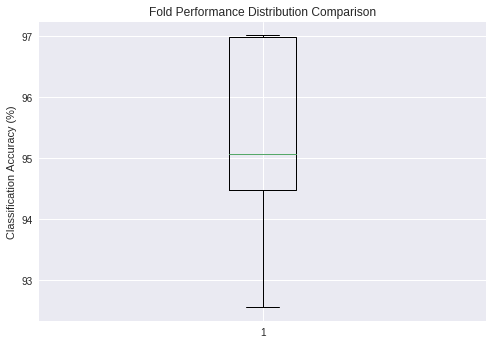

In [25]:
accuracies = []
for fold in range(number_of_folds):
    accuracies.append(k_fold_results[str(fold)]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
# plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_20_BASE:
     plt.savefig(RESULTS_PATH + "boxplot_20_base.pdf", format='pdf')

In [0]:
K.clear_session()

# Six-Fold Cross-Validation
Same method as employed when comparing the original model except this time user all users.

In [0]:
results_six_fold = {}
for user in users:
    results_six_fold[user] = {}

In [28]:
average_accuracy = 0
average_loss = 0
for user in users:
    data_split = split_train_validation_test(user)
    train_data = data_split["train_data"]
    train_labels = data_split["train_labels"]
    validation_data = data_split["validation_data"]
    validation_labels = data_split["validation_labels"]
    test_data = data_split["test_data"]
    test_labels = data_split["test_labels"]
    
    model = make_base_model()

    history = model.fit(train_data, train_labels,
                        batch_size=batch_size,
                        epochs=nb_epochs,
                        shuffle=True, 
                        validation_data=(validation_data, validation_labels),
                        verbose=1)
    
    results = evaluate_model(model, test_data, test_labels, batch_size, target_names)
    average_accuracy += results["accuracy"]
    average_loss += results["loss"]
    results_six_fold[user]["accuracy"] = results["accuracy"]
    results_six_fold[user]["loss"] = results["loss"]

results_six_fold["avg_loss"] = average_loss/len(users)
results_six_fold["avg_acc"] = average_accuracy/len(users)
print("Average Loss:", average_loss/len(users))
print("Average Accuracy:", average_accuracy/len(users))

Train on 29575 samples, validate on 7410 samples
Epoch 1/20
29575/29575 [==============================] - 65s 2ms/step - loss: 0.9011 - acc: 0.6571 - val_loss: 0.5397 - val_acc: 0.8050
Epoch 2/20
29575/29575 [==============================] - 63s 2ms/step - loss: 0.4181 - acc: 0.8531 - val_loss: 0.2271 - val_acc: 0.9167
Epoch 3/20
29575/29575 [==============================] - 63s 2ms/step - loss: 0.2831 - acc: 0.8997 - val_loss: 0.1906 - val_acc: 0.9271
Epoch 4/20
29575/29575 [==============================] - 63s 2ms/step - loss: 0.2120 - acc: 0.9216 - val_loss: 0.1401 - val_acc: 0.9487
Epoch 5/20
29575/29575 [==============================] - 63s 2ms/step - loss: 0.1756 - acc: 0.9376 - val_loss: 0.1449 - val_acc: 0.9435
Epoch 6/20
29575/29575 [==============================] - 63s 2ms/step - loss: 0.1522 - acc: 0.9445 - val_loss: 0.1195 - val_acc: 0.9567
Epoch 7/20
29575/29575 [==============================] - 63s 2ms/step - loss: 0.1307 - acc: 0.9526 - val_loss: 0.1225 - val_acc:

## Save Results

In [0]:
if SAVE_RESULTS_6_FOLD_BASE:
    with open(RESULTS_PATH + "results_6_fold_base.pkl", 'wb') as results_file:
        pickle.dump(results_six_fold, results_file)

## Load Results

In [0]:
with open(RESULTS_PATH + "results_6_fold_base.pkl", 'rb') as results_file:
    results_six_fold = pickle.load(results_file)

## Visualize Results

In [30]:
print("Average Accuracy:", results_six_fold["avg_acc"]*100)
print("Average Loss:", results_six_fold["avg_loss"])

Average Accuracy: 77.00016737802326
Average Loss: 2.056575826932806


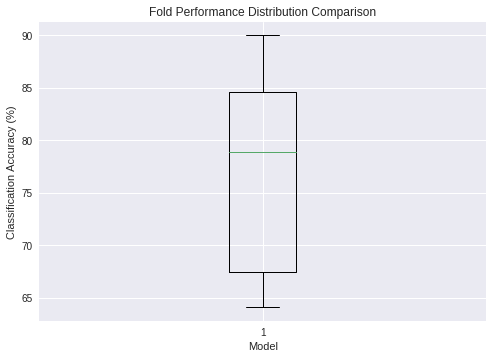

In [31]:
accuracies = []
for user in users:
    accuracies.append(results_six_fold[user]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
     plt.savefig(RESULTS_PATH + "boxplot_6_fold_base.pdf", format='pdf')

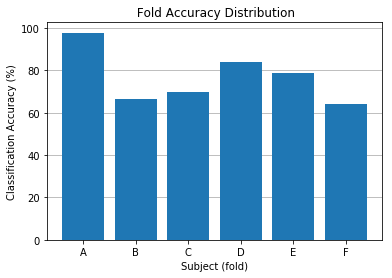

In [0]:
plt.bar(range(len(users)), accuracies, zorder=3)
plt.xticks(range(len(users)), users)
plt.xlabel("Subject (fold)")
plt.ylabel("Classification Accuracy (%)")
plt.title(" Fold Accuracy Distribution")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD_BASE:
    plt.savefig(RESULTS_PATH + "fold_accuracy_distribution_6_fold_base.pdf", format='pdf')
plt.show()